# 使用CNN+MNIST实现手写数字识别

In [70]:
# 导入包
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
from torch import nn

# torch.backends.cudnn.enabled = False # 解决报错
d2l.use_svg_display()   # 以svg格式显示图片

通过框架中内置函数将Fashion-MNIST数据集下载并读到内存中

In [71]:
# 通过ToTensor实例将图像数据从PIL类型转变为32位浮点数类型，并除以255使得所有像素数值均为0，-1
tran = transforms.ToTensor()  # 将图片转tensor
minst_train = torchvision.datasets.MNIST(
    root='../data',train=True,transform=tran,download=True
)
minst_test = torchvision.datasets.MNIST(
    root='../data',train=False,transform=tran,download=True
)

len(minst_test),len(minst_train)  # 变量，变量    这样通过逗号查看变量信息，要比 print（） print（） 便捷

(10000, 60000)

下载完之后，我们比对着来看看效果

In [72]:
def get_mnist_labels(labels):  #@save
    """返回MNIST数据集的文本标签"""
    text_labels = ['0','1','2','3','4','5','6','7','8','9']
    return [text_labels[int(i)] for i in labels]

In [73]:
minst_train[0],minst_train[0][0].shape

((tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0

In [74]:
# 创建一个函数来可视化样本
def show_image(imgs,num_rows,num_cols,titles=None,scale=1.5):    #@save 记录过，会将对应的函数、类、语句保存在d2l包里，以后无需定义即可直接调用他们
    """绘制图像列表"""                                           # scale函数，控制缩放比例
    figsize = (num_cols*scale,num_rows*scale)
    _,axes = d2l.plt.subplots(num_rows,num_cols,figsize=figsize)
    axes = axes.flatten()
    for i, (ax,img) in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


x:
torch.Size([18, 1, 28, 28])


array([<Axes: title={'center': '5'}>, <Axes: title={'center': '0'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '1'}>,
       <Axes: title={'center': '9'}>, <Axes: title={'center': '2'}>,
       <Axes: title={'center': '1'}>, <Axes: title={'center': '3'}>,
       <Axes: title={'center': '1'}>, <Axes: title={'center': '4'}>,
       <Axes: title={'center': '3'}>, <Axes: title={'center': '5'}>,
       <Axes: title={'center': '3'}>, <Axes: title={'center': '6'}>,
       <Axes: title={'center': '1'}>, <Axes: title={'center': '7'}>,
       <Axes: title={'center': '2'}>, <Axes: title={'center': '8'}>],
      dtype=object)

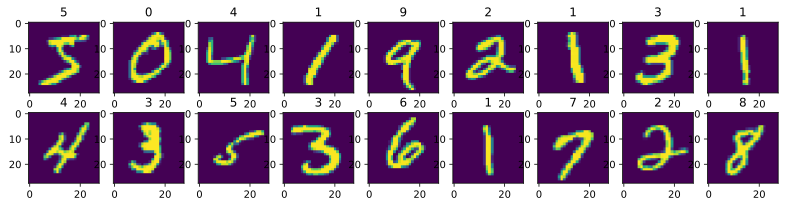

In [75]:
X,y =  next(iter(data.DataLoader(minst_train,batch_size=18)))
print("x:")
print(X.shape)
show_image(X.reshape(18,28,28),2,9,get_mnist_labels(y))    # 训练数据集的y

小批量读数据 + 多进程

In [76]:
# 接下来是数据迭代器
batch_size = 64   # 这里我试过256，128 都不行，报错，批量太大处理不了

def get_dataloader_workers():
    """使用2个进程来读取数据"""
    return 2
train_iter = data.DataLoader(minst_train,batch_size,shuffle=True,num_workers=get_dataloader_workers())
test_iter = data.DataLoader(minst_test,batch_size,shuffle=True,num_workers=get_dataloader_workers())


接下来开始设计net ： LeNet模型

In [77]:
# 接下来开始设计net ： LeNet模型
net = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),   # AvgPool2d池化
    nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120),nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),
    nn.Linear(84,10)
)

对上述代码的一些解释：
+  AvgPool2d池化
+ nn.Flatten()：Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到全连接层的过渡。Flatten不影响batch的大小。

In [78]:
# 接下来是检查模型操作，打印输出形状，以确保其操作和我们期望的形状一致
X = torch.rand(size = (1,1,28,28),dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'\t',X.shape)                                         

Conv2d 	 torch.Size([1, 6, 28, 28])
Sigmoid 	 torch.Size([1, 6, 28, 28])
AvgPool2d 	 torch.Size([1, 6, 14, 14])
Conv2d 	 torch.Size([1, 16, 10, 10])
Sigmoid 	 torch.Size([1, 16, 10, 10])
AvgPool2d 	 torch.Size([1, 16, 5, 5])
Flatten 	 torch.Size([1, 400])
Linear 	 torch.Size([1, 120])
Sigmoid 	 torch.Size([1, 120])
Linear 	 torch.Size([1, 84])
Sigmoid 	 torch.Size([1, 84])
Linear 	 torch.Size([1, 10])


## 模型训练
*通过使用GPU加速模型训练*

In [79]:
def evaluate_accuracy_gpu(net,data_iter,device=None):   #@save
    '''使用GPU计算模型在数据集上的精度'''
    if isinstance(net,nn.Module):  # isinstance函数： 判断参数1 是不是参数2 类型的 ，net 是 nn.Module类型
        net.eval()   # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X,y in data_iter:
            if isinstance(X,list):
                # BERT微调？
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

在进行前向和反向传播之前，我们还需要将每个小批量数据移动到我们指定的GPU设备

In [80]:
#@SAVE
def train(net,train_iter,test_iter,num_epochs,lr,device):
    """用GPU训练模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on',device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(),lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],
                            legend=['train_loss','train_ace','test_acc'])
    timer,num_batches = d2l.Timer(),len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i,(X,y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X,y = X.to(device),y.to(device)
            y_hat = net(X)
            l = loss(y_hat,y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0],d2l.accuracy(y_hat,y),X.shape[0])
            timer.stop()
            train_l = metric[0]/metric[2]
            train_acc = metric[1]/metric[2]
            if (i + 1)%(num_batches//5) == 0 or i == num_batches -1:
                animator.add(epoch+(i+1)/num_batches,
                             (train_l,train_acc,None))
        test_acc = evaluate_accuracy_gpu(net,test_iter)
        animator.add(epoch+1,(None,None,test_acc))
    print(f'loss{train_l:.3f},train_acc:{train_acc:.3f},test_acc{test_acc:3f}')
    print(f'{metric[2]*num_epochs/timer.sum():.1f}example/sec on {str(device)}')

loss0.103,train_acc:0.968,test_acc0.970600
5316.3example/sec on cuda:0


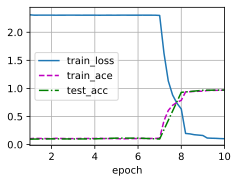

In [81]:
# 接下来训练评估
lr,num_epochs = 0.9,10
train(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

pytorch保存模型导出onnx模型

In [104]:
# 保存pytorch模型
torch.save(net, 'model.pth')

## 读取模型
model = torch.load('model.pth')

In [136]:
import torch.onnx
dummy_input = torch.randn(1, 1, 28, 28,device='cuda')  # 输入样本示例，torch.randn函数用于生成随机数填充张量，这里生成了一个服从标准正态分布的张量。参数device='cuda’ 注意我们训练时用的是GPU训练的，因此导出要用到device='cuda'
onnx_output_path = 'E://model.onnx'  # 输出的ONNX模型文件路径,直接保存到工作目录下：'model.onnx'
net
torch.onnx.export(model, dummy_input, onnx_output_path)

为了更直观的看到效果，接下来我们自己手写个图片进行识别：
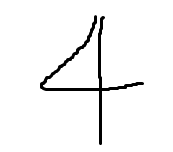

In [131]:
import cv2
import numpy as np
img = cv2.imread("E:\\four.jpg",0)
img = cv2.resize(img,(28,28)) # 转化为数据集对应的大小

# 因为MNIST数据集中的图片都是黑底白字，所以此处还需要图片进行反色处理。
height,width=img.shape
dst=np.zeros((height,width),np.uint8)
for i in range(height):
    for j in range(width):
        dst[i,j]=255-img[i,j]

img = dst

# 处理完成后的图片和之前的步骤就一样了，送入网络，输出结果

img=np.array(img).astype(np.float32)
img=np.expand_dims(img,0)
img=np.expand_dims(img,0)#扩展后，为[1，1，28，28]
img  # 先测试下结果
img=torch.from_numpy(img)
img = img.to(d2l.try_gpu())   
"""
nput type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same:
错误内容大概就是指输入类型是CPU（torch.FloatTensor），而参数类型是GPU（torch.cuda.FloatTensor）。
这个时候就要补充上：
img = img.to(d2l.try_gpu()) 
"""

'\nnput type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same:\n错误内容大概就是指输入类型是CPU（torch.FloatTensor），而参数类型是GPU（torch.cuda.FloatTensor）。\n这个时候就要补充上：\nimg = img.to(d2l.try_gpu()) \n'

In [132]:
from torch.autograd import Variable
import torch.nn.functional as F
output=net(Variable(img))
prob = F.softmax(output, dim=1)
prob = Variable(prob)
prob = prob.cpu().numpy()  #用GPU的数据训练的模型保存的参数都是gpu形式的，要显示则先要转回cpu，再转回numpy模式
print(f'{prob}')  #prob是10个分类的概率
pred = np.argmax(prob) #选出概率最大的一个
print(pred.item())
# 下面这个是为了直观，不用科学计数法表示的结果：
rounded_prob = [[round(p, 4) for p in prob[0]]]  # 精确到小数点后4位
print(rounded_prob)

[[9.8603242e-04 1.7780663e-05 4.3321736e-03 7.8917992e-06 7.5016260e-01
  4.6908011e-04 2.4283883e-01 7.8010809e-05 2.9535405e-04 8.1226672e-04]]
4
[[0.001, 0.0, 0.0043, 0.0, 0.7502, 0.0005, 0.2428, 1e-04, 0.0003, 0.0008]]
